In [27]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten,\
                                    Reshape, GlobalMaxPooling2D,\
                                    Dropout, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
import imageio

In [28]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

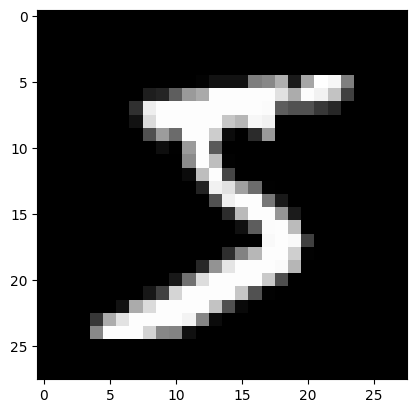

In [29]:
# Plot image data from x_train
plt.imshow(x_train[0], cmap = "gray")
plt.show()

In [30]:
latent_dim = 32
filters = 128
kernel_size = 3
layer_filters = [32, 64]

In [31]:
img = Input(shape = (28, 28, 1))
x = img
for filter in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
    
shape = K.int_shape(x)

x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(img,
                latent,
                name='encoder')
encoder.summary()
# plot_model(encoder,
#            to_file='encoder.png',
#            show_shapes=True)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       1280      
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 latent_vector (Dense)       (None, 32)                200736    
                                                                 
Total params: 349,600
Trainable params: 349,600
Non-trainable params: 0
_________________________________________________________________


In [32]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 32)]              0         
                                                                 
 dense_2 (Dense)             (None, 6272)              206976    
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289 

In [33]:
autoencoder = Model(img,
                    decoder(encoder(img)),
                    name='autoencoder')
autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 32)                349600    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         299521    
                                                                 
Total params: 649,121
Trainable params: 649,121
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [34]:
latent_vector = encoder(img)
output = decoder(latent_vector)

In [35]:
model = Model(inputs = img, outputs = output)
model.compile("nadam", loss = "mean_squared_error")

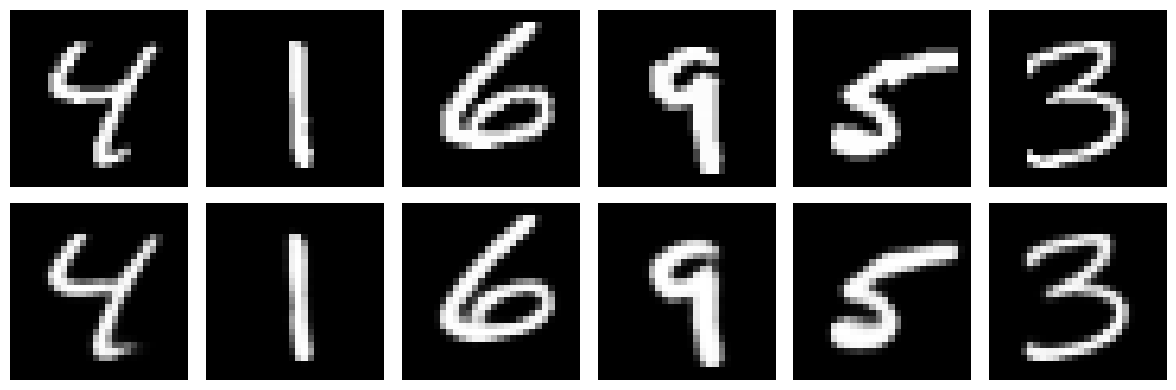

----------- EPOCH 9 -----------
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0029 - val_loss: 0.0031


In [36]:
EPOCHS = 10
HISTORY = []
for epoch in range(EPOCHS):
    fig, axs = plt.subplots(2, 6, 
                            figsize = (12,4), tight_layout=True)

    if i == 0:
        rand = x_test[np.random.randint(0, 10000, 6)].reshape((1, 6, 1, 28, 28))
    
    display.clear_output() # If you imported display from IPython
    
    for i in range(6):
        axs[0, i].imshow(rand[0, i][0], cmap = "gray")
        axs[0, i].axis("off")

        axs[1, i].imshow(model.predict(rand[0, i])[0], cmap = "gray")
        axs[1, i].axis("off")
        
    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.savefig("Reconstruction-{0}.png".format(epoch))
    plt.show()
    print("-----------", "EPOCH", epoch, "-----------")
    history = autoencoder.fit(x_train, x_train, 
                    validation_data=(x_test, x_test),
                    epochs=1, 
                    batch_size=32)

    HISTORY.append(history)

In [37]:
frames = []
for epoch in range(EPOCHS):
    image = imageio.v2.imread("Reconstruction-{0}.png".format(epoch))
    frames.append(image)

In [38]:
imageio.mimsave('./example.gif', # output gif
                frames,          # array of input frames
                fps = 2)   

In [46]:
valMSE = [HISTORY[i].history["val_loss"][0] for i in range(EPOCHS)]
valMSE

[0.004842702299356461,
 0.004047398921102285,
 0.0037793749943375587,
 0.0035813869908452034,
 0.0034967423416674137,
 0.0033022682182490826,
 0.0032644481398165226,
 0.0031525101512670517,
 0.00311124580912292,
 0.003076833439990878]

In [51]:
x_train_latent = encoder.predict(x_train)

In [52]:
x_train_latent.shape

(60000, 32)

In [48]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [49]:
tsne = TSNE().fit_transform(x_train_latent)

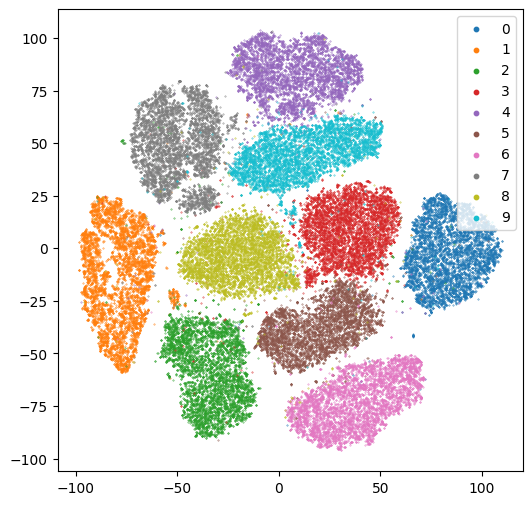

In [50]:
fig, ax = plt.subplots(figsize=(6,6))
for i in range(10):
    indices = np.where(y_train == i)
    ax.scatter(tsne[indices,0], tsne[indices,1], s=.1, label=i)

ax.legend(loc='upper right', markerscale=10)

In [51]:
import umap

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
u = umap.UMAP().fit_transform(x_train_latent)

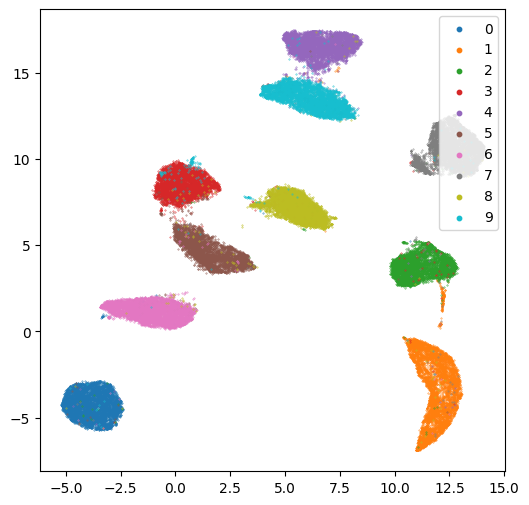

In [53]:
fig, ax = plt.subplots(figsize=(6,6))
for i in range(10):
    indices = np.where(y_train == i)
    ax.scatter(u[indices,0], u[indices,1], s=.1, label=i)

ax.legend(loc='upper right', markerscale=10)